In [0]:
# Packages
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cv2 import equalizeHist
from skimage import filters, morphology
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize
from sklearn.feature_selection import chi2

%matplotlib inline

pp = pprint.PrettyPrinter(indent=2)

# Importing the data

## Importing Functions

In [0]:
def import_data(seed: object = 42) -> object:
    """ Import data from files.

        Note: The data must be in the root of the current working directory
    """

    # Read input data
    df = pd.read_csv("x_train_gr_smpl.csv").astype(int)

    # label data-frame rows based on sample data
    for x in range(10):
        index = ~pd.read_csv("y_train_smpl_%s.csv" % x, squeeze=True).astype(bool)  # reversed flags (~)
        df.loc[index, 'label'] = str(x)

    input_data_ordered = df.iloc[:, 0:2304].to_numpy()
    output_data_ordered = df.iloc[:, 2304].to_numpy()

    # Randomise instance order (forcing the same result each time)
    np.random.seed(seed)
    permutation = np.random.permutation(df.shape[0])

    # Create base input and output arrays
    input_data = input_data_ordered[permutation]
    output_data = output_data_ordered[permutation]

    return input_data, output_data, df, input_data_ordered, output_data_ordered

## Implementation

### Import the data

In [0]:
input_data, output_data, df, input_data_ordered, output_data_ordered = import_data()

# Image labels with classes as dictionary
labels = {
    '0': 'Speed limit 60',
    '1': 'Speed limit 80',
    '2': 'Speed limit 80 lifter',
    '3': 'Right of way at crossing',
    '4': 'Right of way in general',
    '5': 'Give way',
    '6': 'Stop',
    '7': 'No speed limit general',
    '8': 'Turn right down',
    '9': 'Turn left down'
}

In [87]:
# Show first 5 rows to make sure data imported
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,label
0,30,29,28,29,31,30,29,28,27,26,26,26,27,28,30,31,33,33,32,31,29,28,28,29,29,29,29,29,29,28,28,27,28,29,30,32,32,30,29,29,...,38,38,39,40,42,42,41,39,37,39,41,40,40,38,37,36,35,35,35,35,35,35,35,35,35,34,33,32,31,31,32,35,38,39,39,40,39,39,38,0
1,31,31,33,32,31,30,29,28,28,28,29,31,31,29,28,27,29,31,30,30,29,29,28,28,29,29,29,29,30,29,29,27,26,27,27,28,28,27,27,27,...,39,39,37,37,35,36,37,36,33,33,34,34,34,33,33,32,32,34,34,35,34,34,34,34,34,33,32,31,30,32,34,35,36,36,37,38,38,37,37,0
2,30,30,31,29,28,27,26,28,30,31,32,32,29,27,26,26,26,27,28,29,30,28,26,26,26,27,28,30,28,27,28,28,27,26,25,25,25,26,26,24,...,38,36,34,34,35,34,33,33,33,34,35,36,34,33,33,33,34,34,33,33,33,32,32,32,32,31,30,29,31,33,35,37,37,38,39,38,38,39,40,0
3,26,25,24,24,24,27,28,29,29,30,28,27,25,26,27,27,27,27,26,25,25,26,27,27,27,27,28,27,26,25,25,25,26,26,25,24,23,23,24,24,...,33,32,32,31,32,32,32,33,33,33,35,34,33,29,27,28,30,32,31,31,30,30,28,28,29,28,28,28,29,32,34,36,37,38,42,40,37,36,36,0
4,25,26,28,28,28,28,28,27,26,25,25,26,25,25,25,25,25,25,24,24,24,24,25,27,27,25,24,24,24,24,24,24,24,24,25,24,24,23,23,22,...,31,30,30,32,33,35,36,34,34,33,32,31,30,30,32,33,32,32,31,30,30,28,28,27,27,27,27,28,29,30,31,33,37,38,37,36,36,35,35,0


# Data analysis

## Display Functions

In [0]:
import numpy as np

def image_as_square(image: np.ndarray):
    image_width = 48
    image_height = image_width

    return np.resize(image, (image_width, image_height)).astype(np.uint8)


def image_as_array(image: np.ndarray):
    image_width = 48
    image_height = image_width
    return np.resize(image, (image_width * image_height,)).astype(np.uint8)


In [0]:
def is_data_unique(data: np.array) -> bool:
    """
      Compare the shape of the data set to a version which only contains
      unique images.

      If the shapes are equal, then the data only consists of unique images.
    """

    data_shape = data.shape
    unique_data_shape = np.unique(data, axis=0).shape

    if data_shape == unique_data_shape:
        return True

    return False

In [0]:
def display_images_as_grid(images: np.ndarray):
    image_count = len(images)
    column_count = 8
    fig_width = 11

    # Calculate the number of rows needed
    row_count = image_count // column_count

    if image_count % column_count > 0:
        row_count += 1

    # Calulate the figure size so each image isn't tiny
    fig_height = fig_width / column_count * row_count

    # Setup the plot
    fig, axes = plt.subplots(
        nrows=row_count,
        ncols=column_count,
        figsize=(fig_width, fig_height)
    )

    ax = axes.ravel()

    #  Disable axis on all subplots, even those without images
    for i in range(0, len(ax)):
        ax[i].axis('off')

    # Resize images to shape of (48, 48)
    images = np.apply_along_axis(image_as_square, 1, images)

    # Plot the images
    for i in range(0, len(images)):
        image = images[i]
        ax[i].imshow(image, cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(i, color='black')

    fig.tight_layout()


In [0]:
def plot_frequency_distribution(data):
    data_labels = [v for v in labels.values()]

    data = pd.DataFrame({
        'count': pd.Series([
            np.sum((data == '0')),
            np.sum((data == '1')),
            np.sum((data == '2')),
            np.sum((data == '3')),
            np.sum((data == '4')),
            np.sum((data == '5')),
            np.sum((data == '6')),
            np.sum((data == '7')),
            np.sum((data == '8')),
            np.sum((data == '9')),
        ]),
        'class': pd.Categorical(data_labels)
    })

    # Set style
    sns.set_style("white")
    sns.set_style("ticks")

    # Colour palette
    sns.color_palette("hls", 10)

    # Create new figure
    plt.subplots(figsize=(11, 3))
    # Create plot
    sns.barplot(y='class', x='count', data=data, palette='hls')
    plt.xticks(np.linspace(0, 2250, 10))
    # Remove spine
    sns.despine(bottom=True)
    #  Add grid lines
    plt.grid(b=True, which='major', axis='x')
    # Remove axis labels
    plt.ylabel("")
    plt.xlabel("")
    plt.show()


In [0]:
def compare_class_distribution_with_normalized(input_data, output_data):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 2))

    sns.set_style("white")
    sns.set_style("ticks")
    palette = sns.color_palette('hls', 10)

    input_data_normalized = np.zeros(input_data.shape)
    
    for label in range(10):
        x = input_data[output_data.astype(np.int) == label]
        normalized = normalize(x)
        input_data_normalized[output_data.astype(np.int) == label] = normalized
        sns.distplot(x.flatten(), ax=ax[0], hist=False, kde=True, color=palette[int(label)])
        sns.distplot(normalized.flatten(), ax=ax[1], hist=False, kde=True, color=palette[int(label)])

    sns.despine(ax=ax[0], left=True, trim=True)
    sns.despine(ax=ax[1], left=True, trim=True)

    ax[0].get_yaxis().set_ticks([])
    ax[1].get_yaxis().set_ticks([])

    ax[0].grid(b=True, which='major', axis='x')
    ax[1].grid(b=True, which='major', axis='x')

    fig.tight_layout()
    plt.show()

## Implementation

### Check instances within data

In [93]:
def instance_count_per_class(data):
    unique, counts = np.unique(data, return_counts=True)
    count_dict = dict(zip(unique, counts))

    return dict((labels[key], value) for (key, value) in count_dict.items())


# Number of instances in the data set
instance_count = np.shape(input_data)[0]
print(f"Number of images: {instance_count}")

# Check if each instance (row/image) is unique
print(f"Is data unique? {is_data_unique(input_data)}")

# Print number of instances per class
pp.pprint(instance_count_per_class(output_data))


Number of images: 12660
Is data unique? True
{ 'Give way': 2160,
  'No speed limit general': 240,
  'Right of way at crossing': 1320,
  'Right of way in general': 2100,
  'Speed limit 60': 1410,
  'Speed limit 80': 1860,
  'Speed limit 80 lifter': 420,
  'Stop': 780,
  'Turn left down': 300,
  'Turn right down': 2070}


### Plot class frequency distribution

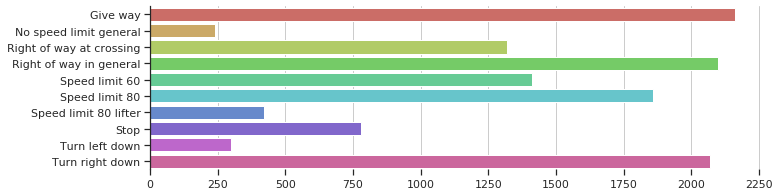

In [94]:
plot_frequency_distribution(output_data)

### Display the images as a grid

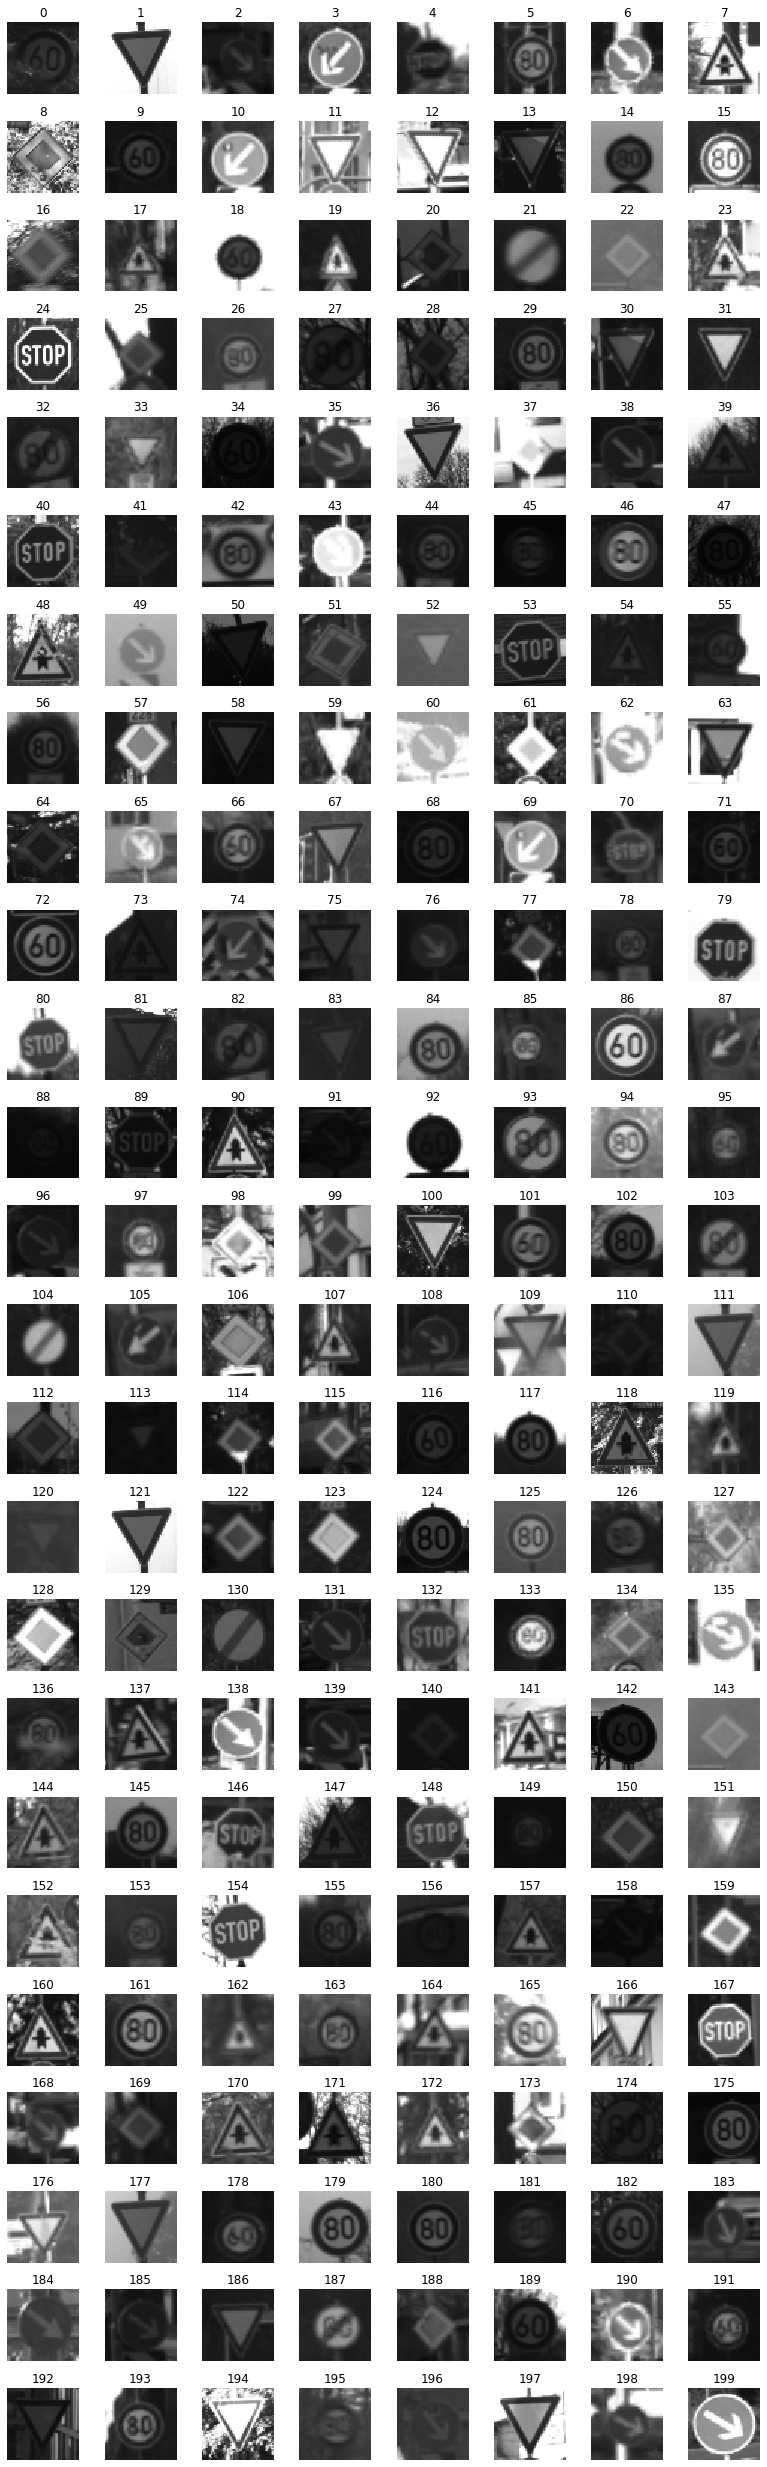

In [0]:
display_images_as_grid(input_data[0:200])

# Naive Bayes

Applying Naive Bayes
1. Split the data in 70/30 for train and test sets respectively
2. Apply Naive Bayes Gaussian variant
3. Predict classification using trained model
4. Display classification report and performance statistics

Notes:
- Using non-random data model predicts 955 out of 3798 signs
- With randomized data model predicts 1125 out of 3798 signs 
- With normalization model predicts 2067 out of 3798 signs
- When overtly enhancing the contrast, model predicts 3257 out of 3798 signs
- Selecting the top featurns improves the model to 3383 of 3798 signs

## Functions

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):

  title = 'Normalized confusion matrix'
  classes = [v for v in labels.values()]

  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_df = pd.DataFrame(cm, index=classes, columns=classes)

  flg, ax = plt.subplots(figsize=(12, 8))
  ax = sns.heatmap(cm_df, annot=True, cmap="Blues")
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)
  ax.set_title(f'{title}')
  ax.set_ylabel('True label')
  ax.set_xlabel('Predicted label')
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score

def print_outcomes(x_test, y_test, y_predictions):
  cm = pd.DataFrame(data=confusion_matrix(y_test, y_predictions), index=labels, columns=labels)
  cr = classification_report(y_test, y_predictions, target_names=list(labels.values()))
  rc = recall_score(y_test, y_predictions, average='weighted')
  f1 = f1_score(y_test, y_predictions, average='weighted')

  print("Outcome:\nNaive Bayes correctly predicted the classification for %s of %s signs using %s attributes\n" 
        % (sum(y_predictions == y_test), len(y_test), x_test.shape[1]))
  print("Classification report:\n%s\n" % cr)
  print("Confusion matrix:\n%s\n" % cm)
  print("Weighted Recall: %.3f" % rc)
  print("Weighted F1: %.3f\n" % f1)

## Running Naive Bayes with different filters

#### Without pre-processing

Outcome:
Naive Bayes correctly predicted the classification for 955 of 3798 signs using 2304 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.42      0.18      0.25       423
          Speed limit 80       0.25      0.27      0.26       558
   Speed limit 80 lifter       0.11      0.92      0.19       126
Right of way at crossing       0.97      0.29      0.44       396
 Right of way in general       0.66      0.09      0.16       630
                Give way       0.35      0.42      0.38       648
                    Stop       0.23      0.32      0.27       234
  No speed limit general       0.18      0.83      0.29        72
         Turn right down       0.29      0.05      0.09       621
          Turn left down       0.00      0.00      0.00        90

                accuracy                           0.25      3798
               macro avg       0.35      0.34      0.23      3798
            

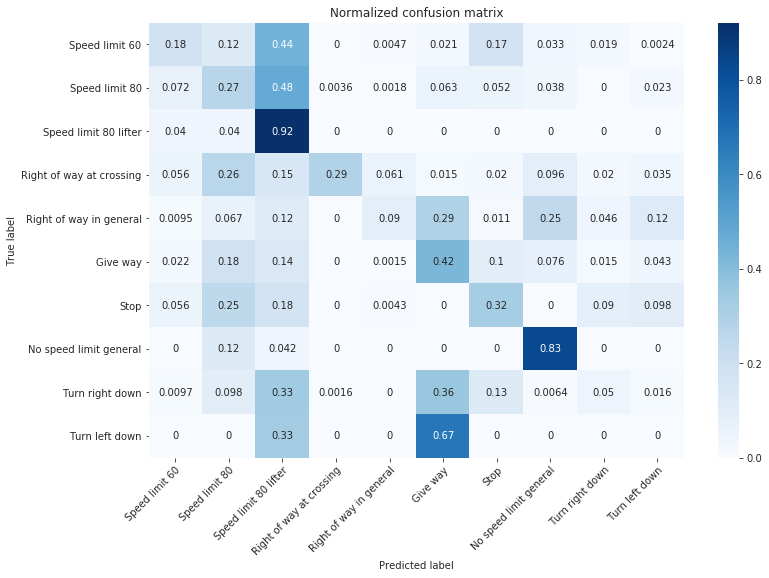

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# split the data into training and test sets for each class
x_train = []
x_test = []
y_train = []
y_test = []

for label in range(10):
    x = input_data_ordered[output_data_ordered.astype(np.int)==label]
    y = output_data_ordered[output_data_ordered.astype(np.int)==label]
    x_train_tmp, x_test_tmp, y_train_tmp, y_test_tmp = train_test_split(x, y, test_size=0.3, shuffle=False)
    x_train.extend(x_train_tmp)
    x_test.extend(x_test_tmp)
    y_train.extend(y_train_tmp)
    y_test.extend(y_test_tmp)
    

# train data sets and use model for predictions 
model = GaussianNB()
model.fit(np.array(x_train), np.array(y_train))
y_predictions = model.predict(np.array(x_test))

print_outcomes(np.array(x_test),np.array(y_test), y_predictions)
plot_confusion_matrix(np.array(y_test), y_predictions)

#### With Randomizing

Outcome:
Naive Bayes correctly predicted the classification for 1125 of 3798 signs using 2304 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.27      0.14      0.18       423
          Speed limit 80       0.25      0.22      0.24       558
   Speed limit 80 lifter       0.10      0.85      0.17       126
Right of way at crossing       0.77      0.34      0.47       396
 Right of way in general       0.80      0.20      0.33       630
                Give way       0.46      0.45      0.46       648
                    Stop       0.39      0.58      0.46       234
  No speed limit general       0.10      0.53      0.16        72
         Turn right down       0.64      0.13      0.21       621
          Turn left down       0.20      0.30      0.24        90

                accuracy                           0.30      3798
               macro avg       0.40      0.37      0.29      3798
           

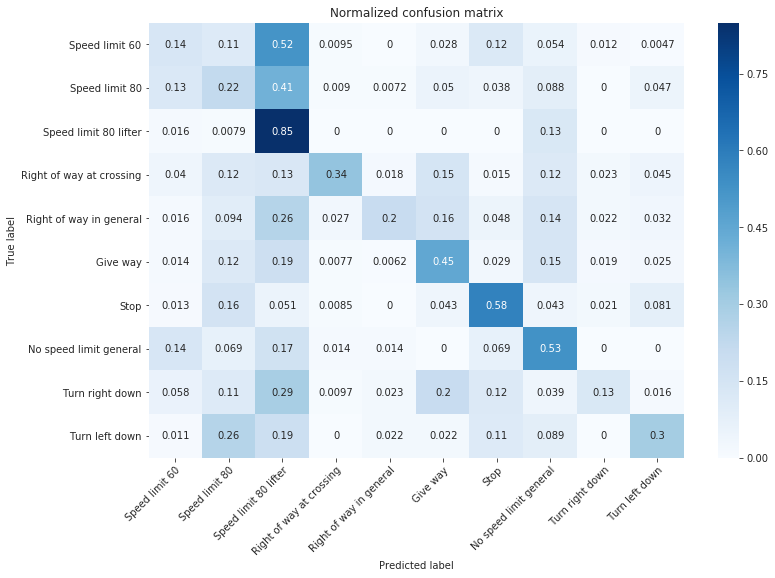

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Run naive bayes on randomized data set
x = input_data
y = output_data

# split the data into training and test sets using stratified random sampling
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=52, stratify=y)

# train data sets and use model for predictions 
model = GaussianNB()
model.fit(x_train, y_train)
y_predictions = model.predict(x_test)

print_outcomes(x_test, y_test, y_predictions)
plot_confusion_matrix(y_test, y_predictions)

#### With Normalization

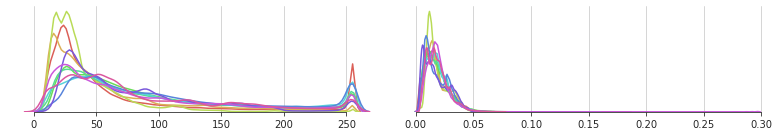

Outcome:
Naive Bayes correctly predicted the classification for 2067 of 3798 signs using 2304 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.30      0.25      0.27       423
          Speed limit 80       0.55      0.37      0.44       558
   Speed limit 80 lifter       0.75      0.73      0.74       126
Right of way at crossing       0.90      0.69      0.78       396
 Right of way in general       0.60      0.39      0.47       630
                Give way       0.92      0.66      0.77       648
                    Stop       0.37      0.81      0.51       234
  No speed limit general       0.09      0.51      0.15        72
         Turn right down       0.60      0.68      0.64       621
          Turn left down       0.45      0.82      0.58        90

                accuracy                           0.54      3798
               macro avg       0.55      0.59      0.54      3798
           

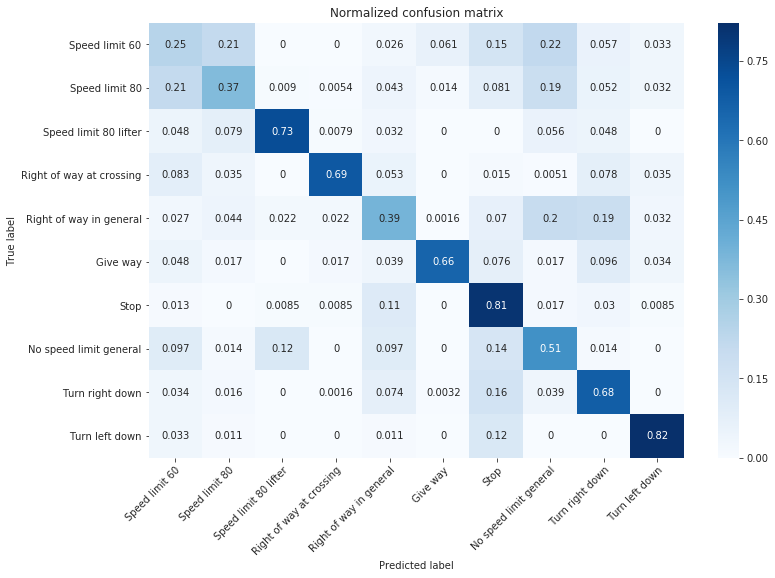

In [0]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Normalize the input data
input_data_normalized = np.zeros(input_data.shape)

for label in range(10):
    x = input_data[output_data.astype(np.int)==label]
    normalized = normalize(x)
    input_data_normalized[output_data.astype(np.int)==label] = normalized

compare_class_distribution_with_normalized(input_data, output_data)

# Run naive bayes on data without image preprocessing
x = input_data_normalized
y = output_data

# split the data into training and test sets using stratified random sampling
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=52, stratify=y)

# train data sets and use model for predictions 
model = GaussianNB()
model.fit(x_train, y_train)
y_predictions = model.predict(x_test)

print_outcomes(x_test, y_test, y_predictions)
plot_confusion_matrix(y_test, y_predictions)

### Interesting find (found too late)

In [0]:
# *** late interesting find resulting in f1-score of 0.97

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='box-cox', standardize=False)
input_data_transformed = np.zeros(input_data.shape)

for label in range(10):
    x = input_data[output_data.astype(np.int)==label]
    transformed = pt.fit_transform(x)
    input_data_transformed[output_data.astype(np.int)==label] = transformed
    sns.set_style('darkgrid')
    sns.distplot(transformed.flatten(), hist=False, norm_hist=True)

## Feature selection

Using Chi2 to determine feature importance for each of the labels of enhanced and normalized datasets

In [0]:
from sklearn.feature_selection import chi2

def display_image_from_array(image: np.array, title):
    # resize the image to 48 x 48 shape
    image = image_as_square(image)

    # Display the image
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

def vizualize_important_features(input_data, output_data):
    X = input_data
    Y = output_data
    feature_importances = chi2(X=X, y=Y)[0]

    N, M = X.shape

    out = {}
    for c in set(Y):
        out[c] = dict(zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances))

    for item in out.items():
        # this transformation is only done for visualisation purposes
        scores = np.fromiter(item[1].values(), dtype=float)
        scores *= 255.0/max(scores)
        display_image_from_array(image=scores, title=f"Label: {item[0]}, Sign: {labels[item[0]]}")



### Visualise important features for normalized data

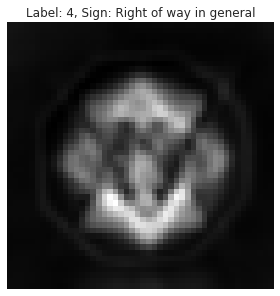

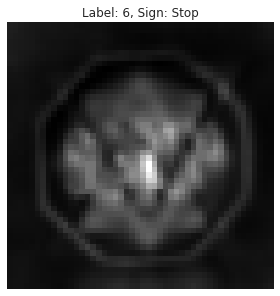

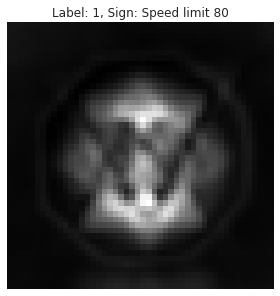

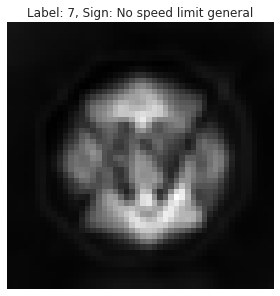

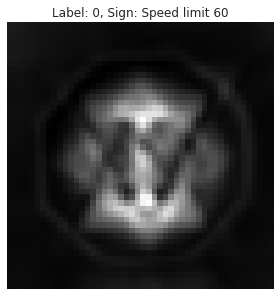

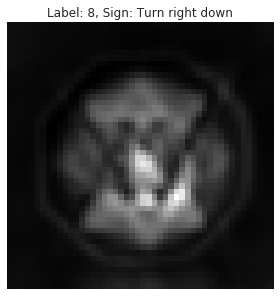

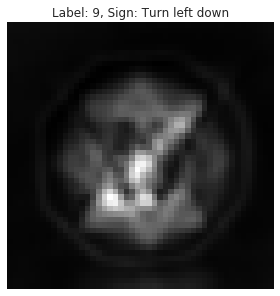

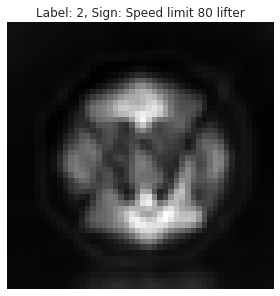

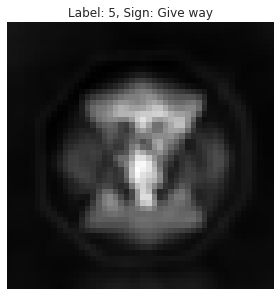

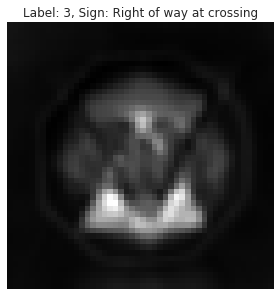

In [0]:
from sklearn.feature_selection import chi2

X = input_data_normalized
Y = output_data
feature_importances = chi2(X=X, y=Y)[0]

N, M = X.shape

out = {}
for c in set(Y):
    out[c] = dict(zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances))

for item in out.items():
    # print("\nLabel: %s, Sign: %s" % (item[0], labels[item[0]]))
    # this transformation is only done for visualisation purposes
    scores = np.fromiter(item[1].values(), dtype=float)
    scores *= 255.0/max(scores)
    display_image_from_array(image=scores, title=f"Label: {item[0]}, Sign: {labels[item[0]]}")

### Top features for each class

In [0]:
from heapq import nlargest


def get_n_best_fetures(X, Y, N, show_: bool = False, print_: bool = False):

    idx = []
    for item in out.items():
        top = nlargest(N, item[1], key=item[1].get)
        idx.extend(top)

        if print_:
            print("\nLabel: %s, Sign: %s" % (item[0], labels[item[0]]))
            print("Selected %s features: %s" % (len(top), top))

    selected_features = list(set(idx))

    if print_:
        print("\n%s selected feature indexes:\n%s" % (len(selected_features), selected_features))

    if show_:
        all_pixels = np.repeat(0, X.shape[1])
        np.put(all_pixels, selected_features, 255)
        display_image_from_array(all_pixels, title="")

    return X[:, selected_features]



from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

def run_naive_bayes(x, y, print_: bool = False):

    # split the data into training and test sets using stratified random sampling
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=52, stratify=y)

    # train data sets and use model for predictions 
    model = GaussianNB()
    model.fit(x_train, y_train)
    y_predictions = model.predict(x_test)

    f1 = f1_score(y_test, y_predictions, average='weighted')
    
    if print_:
        print("\nUsing %s best attributes, f1 score: %.3f\n" % (x.shape[1], f1))
        print_outcomes(x_test, y_test, y_predictions)
        plot_confusion_matrix(y_test, y_predictions)

    return f1

### 2 best attributes for each class

Selecting top 2 features for each class results in total of 9 pixels selected for the model due to overlap of best features between classes. Seemingly random features perform suprisingly good predicting 2481 of 3798 signs (65.3%) in the test data.


Label: 4, Sign: Right of way in general
Selected 2 features: [1555, 1506]

Label: 6, Sign: Stop
Selected 2 features: [1225, 1273]

Label: 1, Sign: Speed limit 80
Selected 2 features: [1561, 840]

Label: 7, Sign: No speed limit general
Selected 2 features: [1518, 1519]

Label: 0, Sign: Speed limit 60
Selected 2 features: [840, 1561]

Label: 8, Sign: Turn right down
Selected 2 features: [1518, 1471]

Label: 9, Sign: Turn left down
Selected 2 features: [1506, 1271]

Label: 2, Sign: Speed limit 80 lifter
Selected 2 features: [1708, 1660]

Label: 5, Sign: Give way
Selected 2 features: [1271, 1224]

Label: 3, Sign: Right of way at crossing
Selected 2 features: [1555, 1554]

14 selected feature indexes:
[1506, 840, 1225, 1224, 1708, 1561, 1518, 1519, 1554, 1555, 1271, 1273, 1660, 1471]


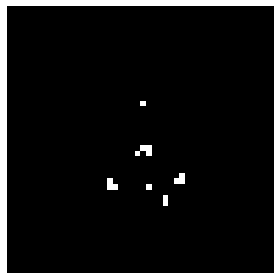


Using 14 best attributes, f1 score: 0.611

Outcome:
Naive Bayes correctly predicted the classification for 2338 of 3798 signs using 14 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.33      0.07      0.11       423
          Speed limit 80       0.47      0.48      0.47       558
   Speed limit 80 lifter       0.58      0.84      0.69       126
Right of way at crossing       0.96      0.70      0.81       396
 Right of way in general       0.67      0.68      0.67       630
                Give way       0.79      0.72      0.76       648
                    Stop       0.27      0.88      0.42       234
  No speed limit general       0.56      0.28      0.37        72
         Turn right down       0.84      0.75      0.79       621
          Turn left down       0.80      0.73      0.76        90

                accuracy                           0.62      3798
               macro avg       0.63

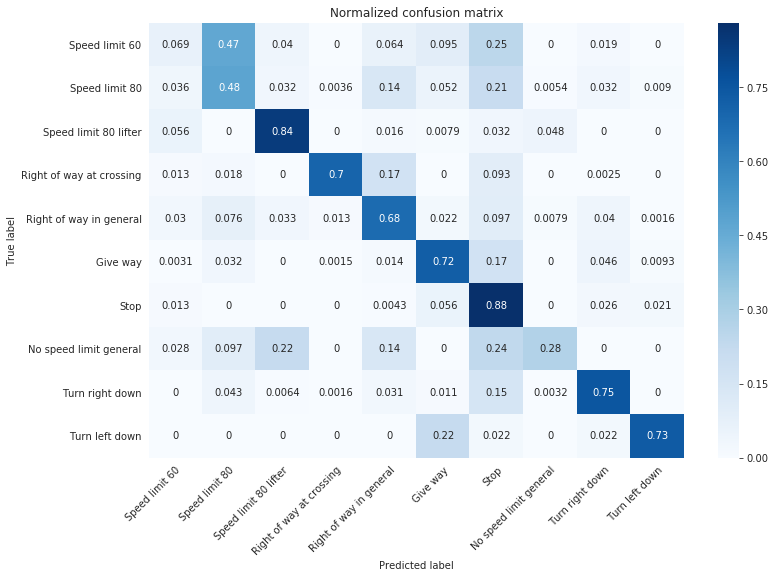

0.6108892634728168

In [0]:
input_data_2_best  = get_n_best_fetures(input_data_normalized, output_data, 2, True, True)
run_naive_bayes(input_data_2_best, output_data, True)

### 5 best attributes for each class

Increasing the number of best attributes to 5 per each class results in a total of 26 attributes selected across all classes. The performance improves to correctly predicting 2868 of 3798 signs (75.5%).


Label: 4, Sign: Right of way in general
Selected 5 features: [1555, 1506, 1518, 1554, 1660]

Label: 6, Sign: Stop
Selected 5 features: [1225, 1273, 1321, 1177, 1369]

Label: 1, Sign: Speed limit 80
Selected 5 features: [1561, 840, 1560, 1512, 1513]

Label: 7, Sign: No speed limit general
Selected 5 features: [1518, 1519, 1660, 1708, 1471]

Label: 0, Sign: Speed limit 60
Selected 5 features: [840, 1561, 1512, 1513, 1560]

Label: 8, Sign: Turn right down
Selected 5 features: [1518, 1471, 1519, 1224, 1566]

Label: 9, Sign: Turn left down
Selected 5 features: [1506, 1271, 1224, 1555, 1507]

Label: 2, Sign: Speed limit 80 lifter
Selected 5 features: [1708, 1660, 840, 1661, 1703]

Label: 5, Sign: Give way
Selected 5 features: [1271, 1224, 1319, 1223, 1272]

Label: 3, Sign: Right of way at crossing
Selected 5 features: [1555, 1554, 1506, 1518, 1603]

28 selected feature indexes:
[1554, 1555, 1560, 1177, 1561, 1566, 1703, 1319, 1321, 1708, 1471, 1603, 1223, 840, 1225, 1224, 1369, 1506, 1507, 

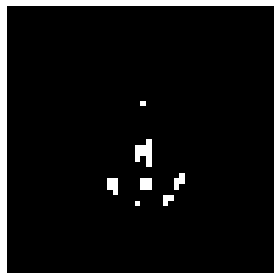


Using 28 best attributes, f1 score: 0.598

Outcome:
Naive Bayes correctly predicted the classification for 2297 of 3798 signs using 28 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.42      0.05      0.08       423
          Speed limit 80       0.45      0.48      0.46       558
   Speed limit 80 lifter       0.42      0.85      0.56       126
Right of way at crossing       0.82      0.75      0.79       396
 Right of way in general       0.71      0.63      0.66       630
                Give way       0.91      0.68      0.78       648
                    Stop       0.28      0.89      0.43       234
  No speed limit general       0.47      0.31      0.37        72
         Turn right down       0.79      0.76      0.77       621
          Turn left down       0.66      0.76      0.70        90

                accuracy                           0.60      3798
               macro avg       0.59

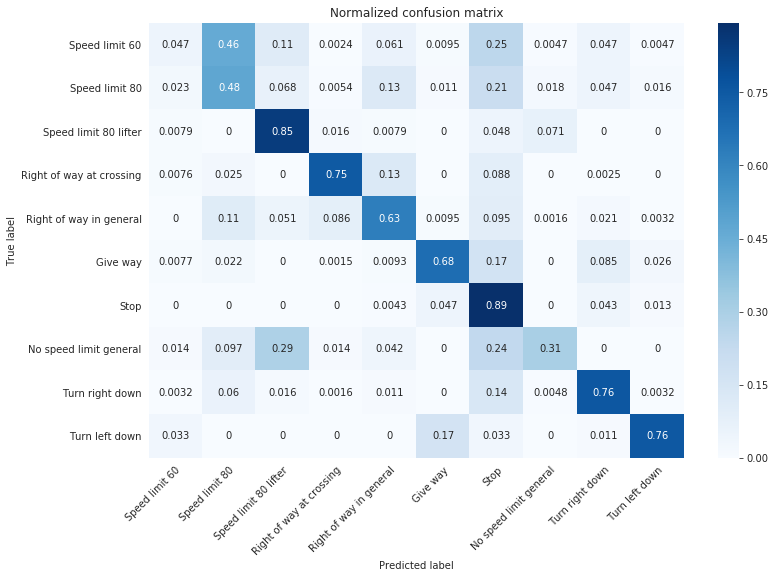

0.5975606553355425

In [0]:
input_data_5_best  = get_n_best_fetures(input_data_normalized, output_data, 5, True, True)
run_naive_bayes(input_data_5_best, output_data, True)

### 10 best attributes for each class

Selecting 10 attributes for each of the classes results in a total of 43 attributes. The performance is slightly improved and the model predicts correctly 3021 of 3798 signs (79.5%).


Label: 4, Sign: Right of way in general
Selected 10 features: [1555, 1506, 1518, 1554, 1660, 1603, 1519, 1613, 1507, 1708]

Label: 6, Sign: Stop
Selected 10 features: [1225, 1273, 1321, 1177, 1369, 1322, 1370, 1224, 1274, 1272]

Label: 1, Sign: Speed limit 80
Selected 10 features: [1561, 840, 1560, 1512, 1513, 792, 794, 793, 841, 1660]

Label: 7, Sign: No speed limit general
Selected 10 features: [1518, 1519, 1660, 1708, 1471, 840, 1566, 1613, 1661, 1561]

Label: 0, Sign: Speed limit 60
Selected 10 features: [840, 1561, 1512, 1513, 1560, 792, 794, 793, 839, 888]

Label: 8, Sign: Turn right down
Selected 10 features: [1518, 1471, 1519, 1224, 1566, 1225, 1470, 1561, 1513, 1176]

Label: 9, Sign: Turn left down
Selected 10 features: [1506, 1271, 1224, 1555, 1507, 1223, 1554, 1319, 1272, 1512]

Label: 2, Sign: Speed limit 80 lifter
Selected 10 features: [1708, 1660, 840, 1661, 1703, 1751, 1561, 1707, 1752, 792]

Label: 5, Sign: Give way
Selected 10 features: [1271, 1224, 1319, 1223, 1272, 

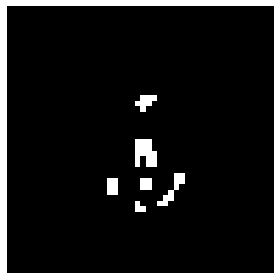


Using 46 best attributes, f1 score: 0.604

Outcome:
Naive Bayes correctly predicted the classification for 2324 of 3798 signs using 46 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.49      0.04      0.07       423
          Speed limit 80       0.44      0.49      0.46       558
   Speed limit 80 lifter       0.54      0.83      0.66       126
Right of way at crossing       0.82      0.74      0.78       396
 Right of way in general       0.70      0.64      0.67       630
                Give way       0.94      0.71      0.80       648
                    Stop       0.28      0.90      0.42       234
  No speed limit general       0.32      0.31      0.31        72
         Turn right down       0.78      0.76      0.77       621
          Turn left down       0.86      0.79      0.82        90

                accuracy                           0.61      3798
               macro avg       0.62

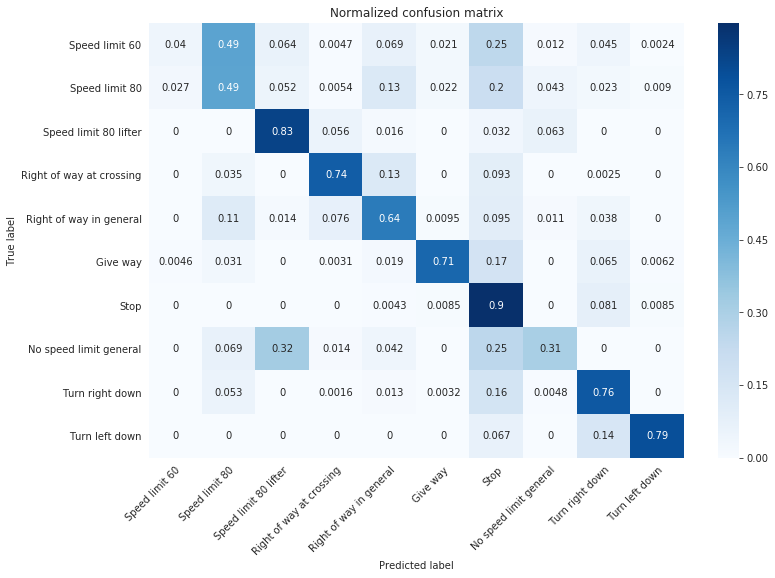

0.6043526507760527

In [0]:
input_data_10_best = get_n_best_fetures(input_data_normalized, output_data, 10, True, True)
run_naive_bayes(input_data_10_best, output_data, True)

### Best number of attributes for each class

Looking for the overall best number of attributes to be selected for each class the model was run on a range of 1 to 2000 best attributes. This is considered a slow method as model needs to be built and assesed for each of the 2000 iterations.

As a result, the best overall balanced accuracy score of 0.891 indicated 136 as the best number of attributes to be selected for each class resulting in a total of 376 attributes. The performance seems to be best around 100 best pixels and drops ever so slightly when increased up to the maxiumum available pixels. This shows that filtering for the most informative attributes, in this case pixels, can not only improve performance and reduce the size of dataset processed and stored, but also is expected to have a positive impact on overal predictive power of a naive bayes model.

In [0]:

x_array = []
y_array = []
best = [0, 0]
print("Looking for best number of attributes for each class...")

for idx in range(1, 2000, 1):
    x = get_n_best_fetures(input_data_normalized, output_data, idx)
    f1 = run_naive_bayes(x, output_data)
    x_array.append(idx)
    y_array.append(f1)
    if f1 > best[1]:
        best = [idx, f1]

print("Best number of attributes: %s, F1 score: %s\n" % (best[0], best[1]))

plt.plot(x_array, y_array)
plt.show()

Looking for best number of attributes for each class...


KeyboardInterrupt: ignored

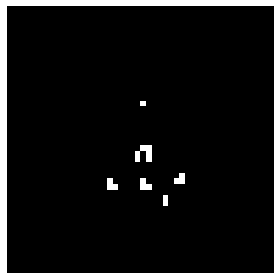


Using 18 best attributes, f1 score: 0.618

Outcome:
Naive Bayes correctly predicted the classification for 2364 of 3798 signs using 18 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.39      0.06      0.11       423
          Speed limit 80       0.46      0.52      0.49       558
   Speed limit 80 lifter       0.46      0.82      0.59       126
Right of way at crossing       0.84      0.74      0.79       396
 Right of way in general       0.72      0.66      0.69       630
                Give way       0.91      0.72      0.80       648
                    Stop       0.28      0.89      0.42       234
  No speed limit general       0.56      0.32      0.41        72
         Turn right down       0.84      0.76      0.80       621
          Turn left down       0.74      0.73      0.74        90

                accuracy                           0.62      3798
               macro avg       0.62

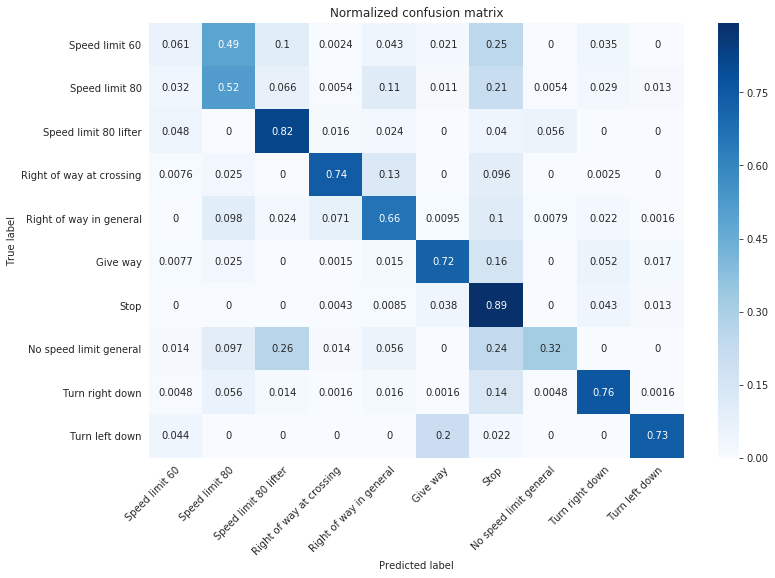

0.6184368361187645

In [0]:
input_data_overall_best = get_n_best_fetures(input_data_normalized, output_data, 3, True)
run_naive_bayes(input_data_overall_best, output_data, True)

### KFold cross validation

Data was split into 5 equally sized bins to perform kfold cross validation on each of the combinations of 4 train and 1 test set - total of 5 runs to validate the model and best number of attributes selected in previous step. The resulted balanced accuracy scores are comparable which indicates a high validity of the selected model and assumptions made.

In [0]:
from sklearn.model_selection import StratifiedKFold

x = input_data_overall_best
y = output_data

skf = StratifiedKFold(n_splits=5)

for train, test in skf.split(x, y):
    f1 = run_naive_bayes(x[train], y[train], False)
    print("Train: %s, Test: %s, F1: %.3f" 
          % (len(x[train]), len(x[test]), f1))

Train: 10128, Test: 2532, F1: 0.612
Train: 10128, Test: 2532, F1: 0.612
Train: 10128, Test: 2532, F1: 0.606
Train: 10128, Test: 2532, F1: 0.605
Train: 10128, Test: 2532, F1: 0.610


# Complex Bayesian Networks

1. Data Transformations to csv
2. Running various classifiers in Weka
3. Comparing the results based on f1-score (visualise with seaborn)

In [0]:
# Stratify function
from sklearn.model_selection import train_test_split

def stratify(x, y, filename, selected_features):
    # split the data into training and test sets using stratified random sampling
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=52, stratify=y)
    
    # make them dataframes
    df_x70 = pd.DataFrame(x_train)
    df_x30 = pd.DataFrame(x_test)
    df_y70 = pd.DataFrame(y_train)
    df_y30 = pd.DataFrame(y_test)

    # Join them all up
    df_x = df_x70.append(df_x30)
    df_y = df_y70.append(df_y30)
    df_y.columns = ['Class']
    df_x.columns = selected_features

    df_stratified = pd.concat([df_x, df_y], axis=1, ignore_index=True)

    # export to csv
    df_stratified.to_csv(f"Weka_{filename}.csv", index=False)

In [0]:
# build csv files for Weka

# FULL DATASET:
stratify(input_data, output_data, "Full_Original")
stratify(enhanced_input_data_hist, output_data, "Full_Enhanced")

# BEST_2:
original_input_data_2_best = get_n_best_fetures(input_data, output_data, 2, True)
enhanced_input_data_2_best = get_n_best_fetures(enhanced_input_data_hist, output_data, 2, True)
stratify(original_input_data_2_best, output_data, "2_Best_Original")
stratify(enhanced_input_data_2_best, output_data, "2_Best_Enhanced")

# BEST_5:
original_input_data_5_best = get_n_best_fetures(input_data, output_data, 5, True)
enhanced_input_data_5_best = get_n_best_fetures(enhanced_input_data_hist, output_data, 5, True)
stratify(original_input_data_5_best, output_data, "5_Best_Original")
stratify(enhanced_input_data_5_best, output_data, "5_Best_Enhanced")

# BEST_10:
original_input_data_10_best = get_n_best_fetures(input_data, output_data, 10, True)
enhanced_input_data_10_best = get_n_best_fetures(enhanced_input_data_hist, output_data, 10, True)
stratify(original_input_data_10_best, output_data, "10_Best_Original")
stratify(enhanced_input_data_10_best, output_data, "10_Best_Enhanced")

# Clustering

## Evaluation of clustering algorithms

**Evaluation of Clustering Algorithms**

The evaluation of clustering algorithms is quite different from normal cases (of supervised learning) where there is a known (confirmed) value associated with the data passed. This is not always the case with clustering. Two classes of evaluation metrics exist depending on weather the 'class' (or label) associated with data is known or not. 

(source: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

1.   Ground truth dependent metrics

*   **Adjusted Rand Index** ('ari'): This is a measure of the similarity between the actual labels assigned to the instances and to the predicted labels. Are all the instances in one present in the other. It is symmetric in the sense that order of passing variables does not matter to the function. 1.0 is considered the perfect score that all the instances belonging to one actual label are predicted to be in the same cluster. A score 0.0 implies there is no correlation between the actual and predicted labels, the clustering is more or less random. 

*   **Adjusted mutual Info Score** ('ami'), **normalized mutual info score** (nmi): Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. NMI is the more prominent one present in literature, AMI was more recently proposed. Mutual Information as a mathematical concept is a function of the entropy of the class. A higher value (bound by 1.0) means more similarity of distribution of instances between actual and predicted labels, a lower value indicates that the instances are spread differently in predicted labels from actual values.

*   **homogenity**: Each cluster contains only members of a single class. (1.0 indicates completely homogenus class with only members of the same class, 0.0 means predicted label contains members from different actual classes). 

*   **completeness**: All the members of the actual class belong to the same cluster (1.0 for proper completeness i.e the statement is true for all classes. 0.0 implies all classes are spread through out different clusters). 

2.   Ground truth independent metrics:

*   **Silhouette Coefficient** ('sc'): A measure of how well defined the clusters are. A high score (upper bound 1.0) implies that the clusters are well separated. A score of 0.0 implies possible overlap between clusters. A further lower score (bound -1.0) implies poor clustering. The Silhouette Coefficient is defined for each sample and is composed of two scores: **a**: The mean distance between one instance and all other instances of the same class. **b**: The mean distance between one instance and all other instances in the nearest neighbouring cluster. 

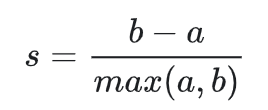

*  **Davies-Bouldin Index** ('dbi'): An alternate and slightly more efficient way of measuring the spearation between clusters. 


## K-means

In [0]:
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import f1_score

In [0]:
# Function to create a Kmeans classfier
# which has been trained with appropriate data.

# Generic function to create a kmeans classfier. 
# This was kept separate as it initially took the input data and 
# trained it as well. Keeping this separate for now. 

def create_trained_classifier(k):
  clf = KMeans(n_clusters=k)
  print("Classifier built with {} Clusters".format(k))
  return clf

# Function to map predicted labels to actual labels 
# Labels predicted as 1, 2 may not correspond to actual '1', '2' in the output class
# Creating a function to map predicted labels to actual labels such that 
# if kmeans is specifying an instance belonging to label 1 (cluster 1) it is implying its 
# predicted actual output as 0 (for instance) and so on. 
# this would enable us to obtain accuracy score and confusion matrix related metrics as if k-means 
# (or any other clustering algorithm) was a supervised learning algorithm. 
def map_predicted_to_actual(labels_true, labels_predicted):
  mapped_labels = np.zeros_like(labels_predicted)
  unique_predicted_labels = list(set(list(labels_predicted)))
  for label in unique_predicted_labels:
    mapped_labels[labels_predicted == label] = mode(labels_true[labels_predicted == label])[0]
  return mapped_labels

# Function to generate the evaluation metrics for clustering algorithms.
def generate_metrics(labels_true, labels_predicted, data, metric='euclidean' ):
  metrics_dict = {}
  metrics_dict['ari'] = metrics.adjusted_rand_score(labels_true, labels_predicted)
  metrics_dict['ami'] = metrics.adjusted_mutual_info_score(labels_true, labels_predicted)
  metrics_dict['nmi'] = metrics.normalized_mutual_info_score(labels_true, labels_predicted)
  metrics_dict['homogenity'] = metrics.homogeneity_score(labels_true, labels_predicted)
  metrics_dict['completeness'] = metrics.completeness_score(labels_true, labels_predicted)
  # metrics independent of ground truth (actual labels assigned to data instances before hand)
  metrics_dict['sc'] = metrics.silhouette_score(data, labels_predicted, metric=metric)
  metrics_dict['dbi'] = metrics.davies_bouldin_score(data, labels_predicted)
  # supervised learning metrics generated as if this was a supervised learning algorithm
  mapped_labels = map_predicted_to_actual(labels_true, labels_predicted)
  metrics_dict['f1-score'] = f1_score(labels_true, mapped_labels, average='weighted')
  return metrics_dict


In [0]:
# Creating a dictionary to store the metrics obtained in different setups. 
# This will be used in the end to create a dataFrame of evaluation metrics 
# to plot and compare the perfromance of kmeans in different setups.

metrics_dict = {}

### K-Means without class field

In [0]:
# Setting number of clusters K as 10 for now as there are 10 classes.
k = 10 
x = input_data
y= output_data.astype(np.int32)
x = x.astype('float')/255

raw_k_means = create_trained_classifier(k)

labels = raw_k_means.fit_predict(x)
metrics_raw = generate_metrics(y, labels, x)
print(metrics_raw)
metrics_dict["Kmeans on Raw data"] = metrics_raw

Classifier built with 10 Clusters


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


{'ari': 0.030428876184745702, 'ami': 0.09024665147213017, 'nmi': 0.09199034008458612, 'homogenity': 0.09235892891628769, 'completeness': 0.09162322222844098, 'sc': 0.14103613323297848, 'dbi': 2.184830230754841, 'f1-score': 0.2020789882358819}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### K-means including the class field

In [0]:
input_df = pd.DataFrame(x)
input_df["output"] = y
x_new = input_df.to_numpy()

k_means_clf = create_trained_classifier(k)
labels_new = k_means_clf.fit_predict(x_new)
dependent_metrics_raw_with_output = generate_metrics(y, labels_new, x)

print(dependent_metrics_raw_with_output)

metrics_dict["Kmeans on Raw data with output"] = dependent_metrics_raw_with_output

Classifier built with 10 Clusters


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


{'ari': 0.11494002114865243, 'ami': 0.20840663787310212, 'nmi': 0.21316673523907692, 'homogenity': 0.21682166528766164, 'completeness': 0.2095734157940374, 'sc': 0.03648551937741308, 'dbi': 3.382653602794305, 'f1-score': 0.23878929083607717}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### K-means with PCA (dimensionality reduction)

In [0]:
x = input_data
y = output_data.astype(np.int32)

# reducing to 1000 dimensions (1000 being arbitarary here)
pca = PCA(n_components=1000)

x_reduced = pca.fit_transform(x)

k_means_clf = create_trained_classifier(k)

labels_with_pca = k_means_clf.fit_predict(x_reduced)

dependent_metrics_pca = generate_metrics(y, labels_with_pca, x_reduced)

print(dependent_metrics_pca)

metrics_dict["Kmeans with PCA on raw data"] = dependent_metrics_pca

Classifier built with 10 Clusters


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


{'ari': 0.030259011429014385, 'ami': 0.09086969946901569, 'nmi': 0.09258377861221147, 'homogenity': 0.09292249486770565, 'completeness': 0.09224629702763198, 'sc': 0.14088443837396022, 'dbi': 2.1804805957559514, 'f1-score': 0.20240857691944625}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### K-means with PCA (dimensionality reduction) (with labels)

In [0]:
x = input_data
y = output_data.astype(np.int32)
pca = PCA(n_components=1000)
x_reduced = pd.DataFrame(pca.fit_transform(x))

x_reduced['output'] = y
x_reduced = x_reduced.to_numpy()

k_means_clf = create_trained_classifier(k)

labels_with_pca_including_output = k_means_clf.fit_predict(x_reduced)

dependent_metrics_pca_including_output = generate_metrics(y, labels_with_pca_including_output, x_reduced)

print(dependent_metrics_pca_including_output)

metrics_dict["Kmeans with PCA on raw data with output"] = dependent_metrics_pca_including_output

Classifier built with 10 Clusters


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


{'ari': 0.03049412612144542, 'ami': 0.09057388746380703, 'nmi': 0.09231650908080438, 'homogenity': 0.09268447085040168, 'completeness': 0.09195000813698129, 'sc': 0.14177249498817013, 'dbi': 2.18488628277352, 'f1-score': 0.20349916861359688}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gaussian Mixture Models (GMM)

### GMM without class field

In [0]:
from sklearn import mixture

x = input_data
y = output_data.astype(np.int32)

gmm = mixture.GaussianMixture(n_components=10)

labels = gmm.fit_predict(x)
gmm_metrics = generate_metrics(y, labels, x)
print(gmm_metrics)
metrics_dict["GMM on Raw Data"] = gmm_metrics

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


{'ari': 0.03131248139903714, 'ami': 0.09599198822209025, 'nmi': 0.09819396786287085, 'homogenity': 0.09737138887091619, 'completeness': 0.09902349587964532, 'sc': 0.15655918176507905, 'dbi': 2.126829291098576, 'f1-score': 0.19244735425828716}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### GMM with class field

In [0]:
# appending output to input class

x_df = pd.DataFrame(input_data)
x_df['output'] = y
x = x_df.to_numpy()

gmm = mixture.GaussianMixture(n_components=10)

labels = gmm.fit_predict(x)

gmm_with_output_metrics = generate_metrics(y, labels, x)

metrics_dict["GMM on Raw data with Output"] = gmm_with_output_metrics

print(gmm_with_output_metrics)

KeyboardInterrupt: ignored

### GMM with PCA (dimensionality reduction)

In [0]:
# running PCA before GMM

x = input_data
y = output_data.astype(np.int32)

# reducing to 1000 dimensions (1000 being arbitarary here)
pca = PCA(n_components=1000)

x_reduced = pca.fit_transform(x)

gmm = mixture.GaussianMixture(n_components=10)

labels = gmm.fit_predict(x)

gmm_pca_metrics = generate_metrics(y, labels, x)
metrics_dict["GMM with PCA on raw data"] = gmm_pca_metrics
print(gmm_pca_metrics)

## Visulising evaluation metrics

In [0]:
# Converting the nested dict of metrics to a dataframe for convenient plotting

index_of_experiments = list(metrics_dict.keys())

index_of_metrics = list(metrics_dict[index_of_experiments[0]].keys())

metrics_df = pd.DataFrame({'experiment': index_of_experiments})
# need one name and list of corresponding values to initialize the df

for name in index_of_metrics:
  list_of_values = [metrics_dict[x][name] for x in index_of_experiments]
  metrics_df[name] = list_of_values

metrics_df.head(10)

,experiment,ari,ami,nmi,homogenity,completeness,sc,dbi,f1-score
0,Kmeans on Raw data,0.030429,0.090247,0.091990,0.092359,0.091623,0.141036,2.184830,0.202079
1,Kmeans on Raw data with output,0.114940,0.208407,0.213167,0.216822,0.209573,0.036486,3.382654,0.238789
2,Kmeans with PCA on raw data,0.030259,0.090870,0.092584,0.092922,0.092246,0.140884,2.180481,0.202409
3,Kmeans with PCA on raw data with output,0.030494,0.090574,0.092317,0.092684,0.091950,0.141772,2.184886,0.203499
4,GMM on Raw Data,0.031312,0.095992,0.098194,0.097371,0.099023,0.156559,2.126829,0.192447


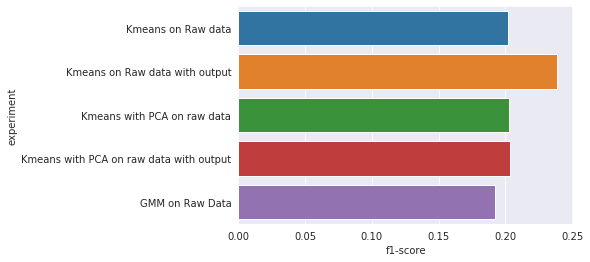

In [0]:
sns.barplot('f1-score', 'experiment', data=metrics_df)

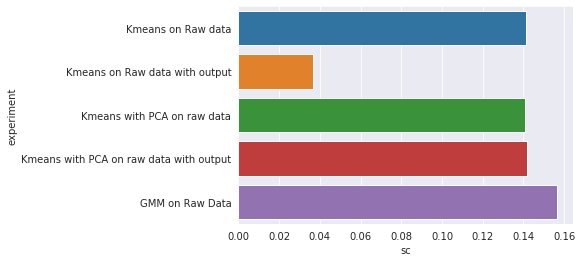

In [0]:
sns.barplot('sc', 'experiment', data=metrics_df)

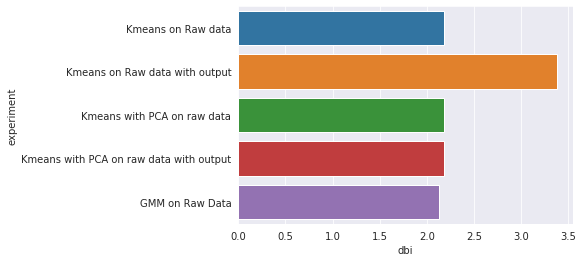

In [0]:
sns.barplot('dbi', 'experiment', data=metrics_df)

# Research Question

In [0]:
def image_equalise_hist(image: np.ndarray): 
    """ Equalise the histogram of the image globally.

        Reference:
        - https://en.wikipedia.org/wiki/Histogram_equalization
        - 
    """
    #  Resize image to a shape of (48, 48)
    image = image_as_square(image)

    #  Equalize the histogram of the image
    image = equalizeHist(image)

    #  Resize the iamge back to a shape of (2304, )
    return image_as_array(image)


def image_thresholding(image: np.ndarray): 
    """ Threshold the image using the Otsu thresholding
        algorithm. 

        Reference: 
        - https://en.wikipedia.org/wiki/Thresholding_(image_processing)
        - https://en.wikipedia.org/wiki/Otsu%27s_method
        - https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html
    """
    #  Resize image to a shape of (48, 48)
    image = image_as_square(image)

    # Find threshold using Otsu filter
    threshold: float = filters.threshold_otsu(image)
    binary = image > threshold

    binary_image = np.where(image, binary, 0) * 255

    #  Resize the iamge back to a shape of (2304, )
    return image_as_array(image)

def image_local_enhance_contrast(image: np.ndarray):
    """ Locally enhance the contrast of the image

        Reference: 
        - https://en.wikipedia.org/wiki/Histogram_equalization
        - https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
        - https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#enhance-contrast
    """
    
    #  Resize image to a shape of (48, 48)
    image = image_as_square(image)

    image = filters.rank.enhance_contrast(image, morphology.disk(2))

    #  Resize the iamge back to a shape of (2304, )
    return image_as_array(image)

def image_local_autolevel(image: np.ndarray):
    """ Stretch histogram to normalise levels

        Reference:
        - https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
        - https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#autolevel
    """
    #  Resize image to a shape of (48, 48)
    image = image_as_square(image)

    image = filters.rank.autolevel(image, morphology.disk(4))

    #  Resize the iamge back to a shape of (2304, )
    return image_as_array(image)

def image_enhance(image: np.ndarray):
    #  Resize image to a shape of (48, 48)
    image = image_as_square(image)

    image = filters.rank.enhance_contrast(image, morphology.disk(2))
    image = filters.rank.autolevel(image, morphology.disk(4))

    #  Resize the iamge back to a shape of (2304, )
    return image_as_array(image)

def enhance_all_images(data): 
    return np.apply_along_axis(image_enhance, 1, input_data)


In [0]:
def display_image_enhancement_comparison(image: np.array):
    def add_plot_line(im, axis):
        ax2 = axis.twinx()
        sns.distplot(im.flatten(), hist=True, bins=30, rug=False, ax=axis, kde=False)
        sns.distplot(im.flatten(), hist=False, rug=False, ax=ax2, kde=True, kde_kws={
            "alpha": 0.8, "cumulative":
                True, 'color': 'r'})
        sns.despine(ax=axis, left=True, right=True)
        sns.despine(ax=ax2, left=True, right=True)
        axis.set_yticks([])
        ax2.set_yticks([])
        axis.set_xticks([0, 50, 100, 150, 200, 250])
        ax2.set_xticks([0, 50, 100, 150, 200, 250])
        axis.set_xlim([0, 255])
        ax2.set_xlim([0, 255])

    hist_equalized_image = image_equalise_hist(image)
    autoleveled_image = image_enhance(image)
    thres_img = image_thresholding(image)
    loc_enhance = image_local_enhance_contrast(image)
    loc_autolev = image_local_autolevel(image)

    widths = [1, 1, 1, 1, 1, 1]
    heights = [4, 1]
    spec = dict(width_ratios=widths, height_ratios=heights)
    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 5), gridspec_kw=spec)

    axes[0, 0].imshow(image_as_square(image), cmap='gray')
    axes[0, 0].set_axis_off()
    axes[0, 0].set_title("Original")
    add_plot_line(image, axes[1, 0])

    axes[0, 1].imshow(image_as_square(hist_equalized_image), cmap='gray')
    axes[0, 1].set_axis_off()
    axes[0, 1].set_title("Histogram equalization")
    add_plot_line(hist_equalized_image, axes[1, 1])

    axes[0, 2].imshow(image_as_square(thres_img), cmap='gray')
    axes[0, 2].set_axis_off()
    axes[0, 2].set_title("Thresholding")
    add_plot_line(thres_img, axes[1, 2])

    axes[0, 3].imshow(image_as_square(loc_enhance), cmap='gray')
    axes[0, 3].set_axis_off()
    axes[0, 3].set_title("Local contrasting")
    add_plot_line(loc_enhance, axes[1, 3])

    axes[0, 4].imshow(image_as_square(loc_autolev), cmap='gray')
    axes[0, 4].set_axis_off()
    axes[0, 4].set_title("Local equalisation")
    add_plot_line(loc_autolev, axes[1, 4])

    axes[0, 5].imshow(image_as_square(autoleveled_image), cmap='gray')
    axes[0, 5].set_axis_off()
    add_plot_line(autoleveled_image, axes[1, 5])

    fig.tight_layout()
    plt.show()

## Comparing different image enhancements

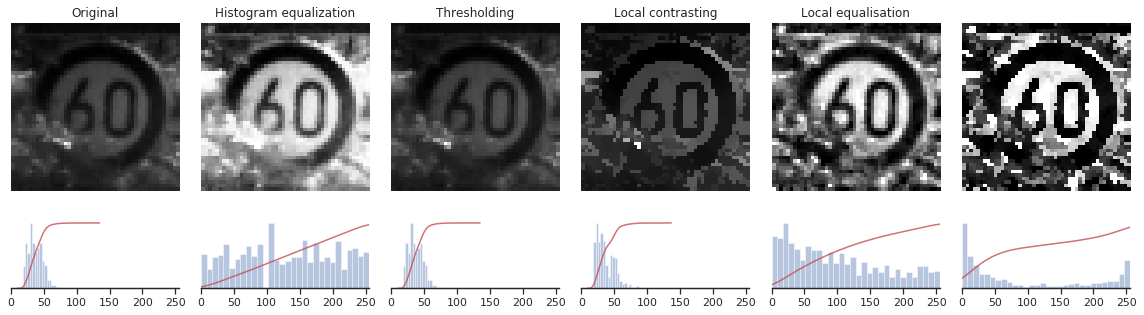

In [99]:
display_image_enhancement_comparison(input_data[0])

## Comparing models

In [0]:
enhanced_input_data = enhance_all_images(input_data)

### Naive Bayes with normalization and image mutations

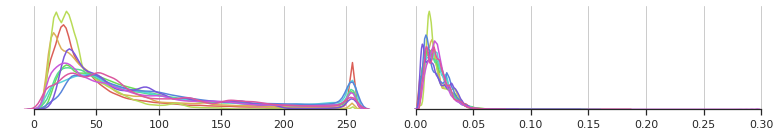

Outcome:
Naive Bayes correctly predicted the classification for 3257 of 3798 signs using 2304 attributes

Classification report:
                          precision    recall  f1-score   support

          Speed limit 60       0.67      0.62      0.64       423
          Speed limit 80       0.58      0.78      0.67       558
   Speed limit 80 lifter       0.99      0.82      0.90       126
Right of way at crossing       1.00      0.90      0.95       396
 Right of way in general       0.94      0.87      0.90       630
                Give way       0.94      0.94      0.94       648
                    Stop       0.99      0.91      0.95       234
  No speed limit general       0.95      0.79      0.86        72
         Turn right down       0.98      0.95      0.96       621
          Turn left down       0.97      0.94      0.96        90

                accuracy                           0.86      3798
               macro avg       0.90      0.85      0.87      3798
           

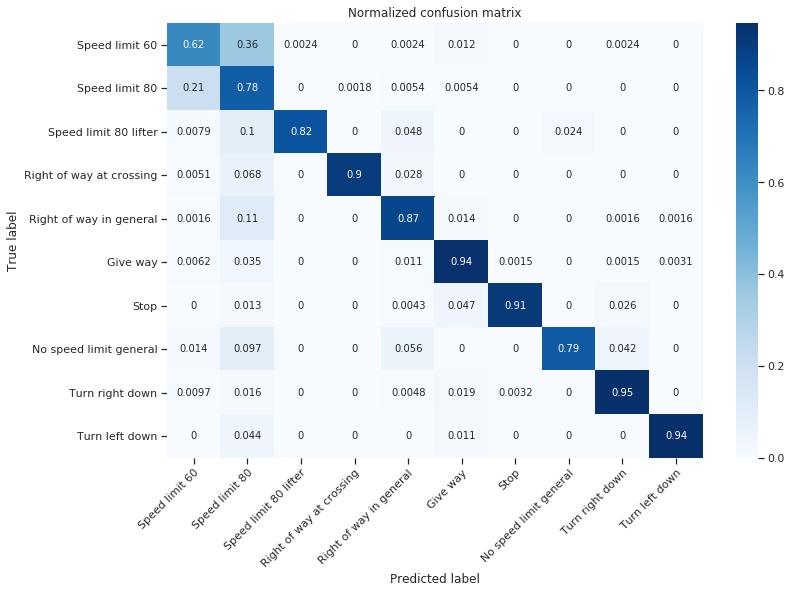

In [102]:
# Normalize the data
enhanced_input_data_normalized = np.zeros(enhanced_input_data.shape)

for label in range(10):
    x = enhanced_input_data[output_data.astype(np.int)==label]
    normalized = normalize(x)
    enhanced_input_data_normalized[output_data.astype(np.int)==label] = normalized

compare_class_distribution_with_normalized(input_data, output_data)

# Run naive bayes on data after image preprocessing
x = enhanced_input_data_normalized
y = output_data

# split the data into training and test sets using stratified random sampling
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=52, stratify=y)

# train data sets and use model for predictions 
model = GaussianNB()
model.fit(x_train, y_train)
y_predictions = model.predict(x_test)

print_outcomes(x_test, y_test, y_predictions)
plot_confusion_matrix(y_test, y_predictions)

### Naive Bayes feature selection with image mutations

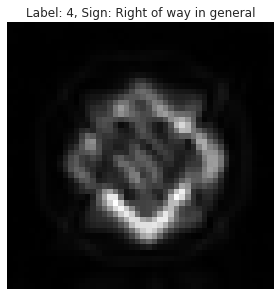

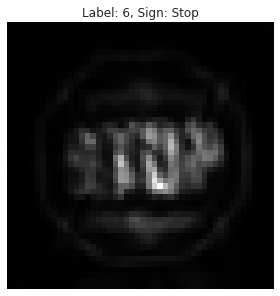

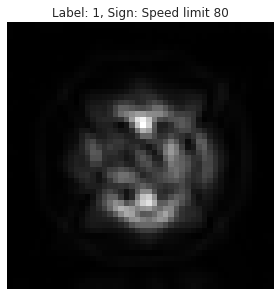

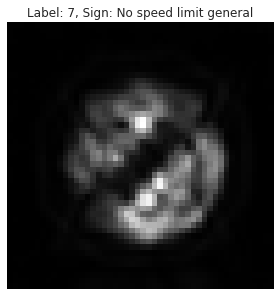

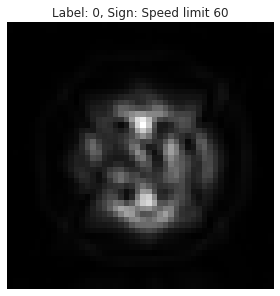

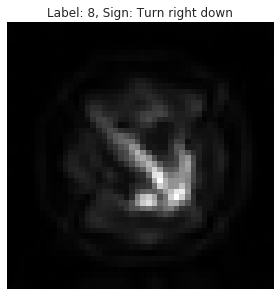

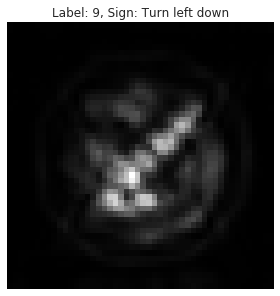

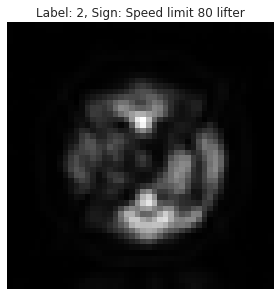

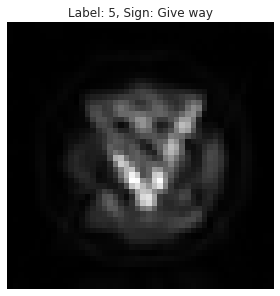

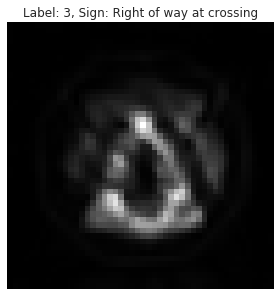

In [103]:
vizualize_important_features(enhanced_input_data_normalized, output_data)

### K-Means with image mutations

#### Without labels

In [0]:
x = enhanced_input_data
y = output_data.astype(np.int32)

k_means_clf = create_trained_classifier(k)
labels_with_enhanced_input = k_means_clf.fit_predict(x)

dependent_metrics_enhanced = generate_metrics(y, labels_with_enhanced_input, x)

print(dependent_metrics_enhanced)

metrics_dict["Enhanced"] = dependent_metrics_enhanced

#### With labels

In [0]:
enhanced_df = pd.DataFrame(enhanced_input_data)
enhanced_df['output'] = y
x_enhanced_with_labels = enhanced_df.to_numpy()

k_means_clf = create_trained_classifier(k)
labels_enhanced_including_actual = k_means_clf.fit_predict(x_enhanced_with_labels)

dependent_metrics_enhanced_with_actual = generate_metrics(y, labels_enhanced_including_actual, x_enhanced_with_labels)


print(dependent_metrics_enhanced_with_actual)

metrics_dict["Enhanced with output"] = dependent_metrics_enhanced_with_actual

#### With PCA

In [0]:
# Running PCA on the enhanced data set
x = enhanced_input_data
y = output_data.astype(np.int32)

pca = PCA(n_components=1000)
x_reduced = pca.fit_transform(x)

k_means_clf = create_trained_classifier(k)

labels = k_means_clf.fit_predict(x_reduced)

enhanced_pca_metrics = generate_metrics(y, labels, x)

print(enhanced_pca_metrics)
metrics_dict["Kmeans with PCA on enhanced data"] = enhanced_pca_metrics

### Gaussian Mixture Models with Image Mutations

In [0]:
# enhanced input
x = enhanced_input_data

gmm = mixture.GaussianMixture(n_components=10)
labels = gmm.fit_predict(x)
print("fit complete")
gmm_enhanced_metrics = generate_metrics(y, labels, x)
metrics_dict["GMM on Enhanced data"] = gmm_enhanced_metrics

print(gmm_enhanced_metrics)

#### with PCA

In [0]:
# GMM with PCA on enhanced
x = enhanced_input_data
y = output_data.astype(np.int32)

pca = PCA(n_components=1000)
x_reduced = pca.fit_transform(x)

gmm = mixture.GaussianMixture(n_components=10)

labels = gmm.fit_predict(x_reduced)

gmm_pca_enhanced = generate_metrics(y, labels, x_reduced)

print(gmm_pca_enhanced)

metrics_dict['GMM with PCA on enhanced data'] = gmm_pca_enhanced

### Comparing performance of image mutations on clustering algorithms

In [0]:
# Converting the nested dict of metrics to a dataframe for convenient plotting

index_of_experiments = list(metrics_dict.keys())

index_of_metrics = list(metrics_dict[index_of_experiments[0]].keys())

metrics_df = pd.DataFrame({'experiment': index_of_experiments})
# need one name and list of corresponding values to initialize the df

for name in index_of_metrics:
  list_of_values = [metrics_dict[x][name] for x in index_of_experiments]
  metrics_df[name] = list_of_values

metrics_df.head(10)

### Comparing performance of models before and after mutations

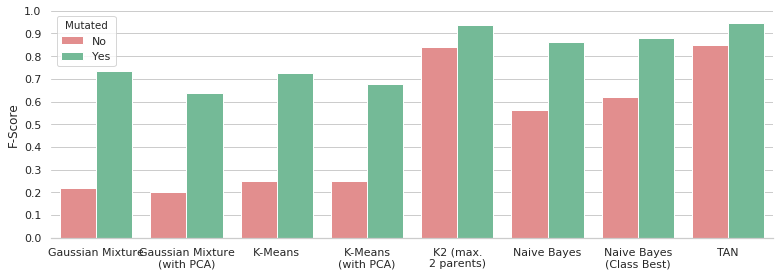

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set(style='whitegrid')
palette = dict(Yes="#69c597", No="#F08080")

# data sets: raw, enhanced
# models: naive full, naive class-best, bayes k2, bayes tan, kmeans, gmm

model_comparison = pd.DataFrame({
    'F-Score': pd.Series([
        0.562,
        0.86,
        0.618,
        0.880,
        0.249131,
        0.723776,
        0.247867,
        0.677946,
        0.219816,
        0.732641,
        0.847,
        0.945,
        0.842,
        0.935,
        0.200787,
        0.637211,
    ]),
    'Mutated': pd.Categorical([
        'No', 'Yes',
        'No', 'Yes',
        'No', 'Yes',
        'No', 'Yes',
        'No', 'Yes',
        'No', 'Yes',
        'No', 'Yes',
        'No', 'Yes'
    ]),
    'Model': pd.Categorical([
        'Naive Bayes',
        'Naive Bayes',
        'Naive Bayes\n(Class Best)',
        'Naive Bayes\n(Class Best)',
        'K-Means',
        'K-Means',
        'K-Means\n(with PCA)',
        'K-Means\n(with PCA)',
        'Gaussian Mixture',
        'Gaussian Mixture',
        'TAN',
        'TAN',
        'K2 (max.\n2 parents)',
        'K2 (max.\n2 parents)',
        'Gaussian Mixture\n(with PCA)',
        'Gaussian Mixture\n(with PCA)'
    ])
})

fig, ax = plt.subplots(figsize=(11, 4))

sns.barplot(x="Model", y="F-Score", data=model_comparison, hue="Mutated", palette=palette, ax=ax)
sns.despine(left=True)
plt.yticks(np.arange(0, 11) / 10)
plt.ylim([0, 1])
plt.xlabel('')

fig.tight_layout()
plt.show()
